This notebook will be used to process Sentinel-2 L2A products from GEE. These products have RGB, NIR, and SWIR1, as well as NDVI, NDWI, MSAVI2, and BSI spectral indices. Otsu thresholding is used on the NIR, SWIR1, NDVI,

Assuming the images have been downloaded from GEE Python API (check notebook "01_sentinel_one_two.ipynb" under the "gee_python" folder).

1. Load in the .tif files and the needed bands using gdal or similar
2. Label the RGB imagery using NDVI and NDWI thresholding as water or land
3. Save the classified image for labeling Sentinel-1 imagery

# Import depenedencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
import rasterio
from sklearn.decomposition import PCA
import numpy as np
import os
from skimage.filters import threshold_otsu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import cv2
from osgeo import gdal, osr
from datetime import datetime
from scipy.stats import mode
import copy

# Functions

In [ ]:
# functions
def map_indices(imagepath):
    with rasterio.open(imagepath) as ind_src:
        ndvi = ind_src.read(1)  # Read first band (assume NDVI is in first band)
        ndwi = ind_src.read(2)  # Read first band (assume NDVI is in first band)
        msavi2 = ind_src.read(3)  # Read first band (assume NDVI is in first band)
        bsi = ind_src.read(4)  # Read first band (assume NDVI is in first band)
    
    
    # Visualizing each band using matplotlib
    plt.figure(figsize=(10, 10))

    # NDVI visualization
    plt.subplot(2, 2, 1)
    plt.imshow(ndvi, cmap='RdYlGn')  # 'RdYlGn' is a color map for NDVI-like data
    plt.colorbar(label='NDVI')
    plt.title('NDVI')

    # NDWI visualization
    plt.subplot(2, 2, 2)
    plt.imshow(ndwi, cmap='Blues')  # 'Blues' is good for water index
    plt.colorbar(label='NDWI')
    plt.title('NDWI')

    # MSAVI2 visualization
    plt.subplot(2, 2, 3)
    plt.imshow(msavi2, cmap='Greens')  # 'Greens' for vegetation index
    plt.colorbar(label='MSAVI2')
    plt.title('MSAVI2')

    # BSI visualization
    plt.subplot(2, 2, 4)
    plt.imshow(bsi, cmap='BrBG')  # 'BrBG' for contrast between soil and water
    plt.colorbar(label='BSI')
    plt.title('BSI')

    plt.tight_layout()
    plt.show()

    return ndvi, ndwi, msavi2, bsi

def normalize_rgb(rgb):
    """Normalize the RGB values to the range [0, 255]."""
    rgb_min, rgb_max = np.min(rgb), np.max(rgb)
    rgb_normalized = (rgb - rgb_min) / (rgb_max - rgb_min)  # Normalize to [0, 1]
    rgb_normalized *= 255  # Scale to [0, 255]
    return rgb_normalized.astype(np.uint8)  # Convert to uint8 for display

def plot_majvote_with_rgb(rgb_path, majority_vote):
    # Open the RGB image
    with rasterio.open(rgb_path) as rgb_src:
        rgb = rgb_src.read([3, 2, 1])  # Read the first three bands (R, G, B)
        rgb = np.moveaxis(rgb, 0, -1)  # Rearrange dimensions to (height, width, bands)
        rgb = normalize_rgb(rgb)  # Normalize the RGB image to [0, 255]

        transform = rgb_src.transform
        height, width = rgb.shape[:2]
        top_left = rasterio.transform.xy(transform, 0, 0, offset='center')
        bottom_right = rasterio.transform.xy(transform, height-1, width-1, offset='center')

    # Extract easting and northing from the corners
    min_easting, max_northing = top_left
    max_easting, min_northing = bottom_right

    # Define a custom colormap for the classifications
    cmap = ListedColormap(['black', 'white'])  # Blue for class 0, Green for class 1, Red for class 2

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))  # 5 subplots for RGB, Otsu, K-Means, GMM, and Majority Vote

    # RGB image visualization
    ax[0].imshow(rgb, extent=[min_easting, max_easting, min_northing, max_northing])
    ax[0].set_title(f'{rgb_path[-14:4]} True Color')
    ax[0].set_xlabel('Easting (meters)')
    ax[0].set_ylabel('Northing (meters)')
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Custom legends for classification plots
    white_patch = mpatches.Patch(color='white', label='Subaerial')
    black_patch = mpatches.Patch(color='black', label='Subaqeuous')
    
    # Majority vote classification visualization
    ax[1].imshow(majority_vote, cmap=cmap, extent=[min_easting, max_easting, min_northing, max_northing])
    ax[1].set_title('Majority Vote')
    ax[1].set_xlabel('Easting (meters)')
    ax[1].legend(handles=[black_patch, white_patch], loc='lower right', title="Classification")
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(5))  # Reduce x-axis ticks

    # Show the plot with layout adjustments
    plt.tight_layout()
    plt.show()

def export_labels_to_tif(labels, reference_tif_path, output_tif_path):
    # Open the reference Sentinel-1 image to get the transform and CRS
    with rasterio.open(reference_tif_path) as src:
        transform = src.transform
        crs = src.crs
        
        height, width = labels.shape

        # Define metadata for the new GeoTIFF file
        meta = src.meta.copy()
        meta.update({
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'count': 1,  # Single band (the labels)
            'dtype': 'uint8',  # Assuming the labels are 0 or 1
            'crs': crs,
            'transform': transform
        })

        # Write the labels array to a new GeoTIFF file
        with rasterio.open(output_tif_path, 'w', **meta) as dst:
            dst.write(labels.astype('uint8'), 1)  # Write the labels as the first band

def get_rgb_avg(rgb_avg_path, combined_ims):
    # Open all the combined .vrt files and read their bands
    all_bands = []
    
    # Loop over each file to read its bands
    for f in combined_ims:
        ds = gdal.Open(f)
        bands = [ds.GetRasterBand(i+1).ReadAsArray() for i in range(ds.RasterCount)]
        all_bands.append(bands)
    
    # Stack the bands across all images (axis=0 for stacking across different images)
    stacked_bands = [np.stack([image_bands[i] for image_bands in all_bands], axis=0) for i in range(len(all_bands[0]))]
    
    # Compute the mean for each band across the stacked images (axis=0 is across images)
    mean_bands = [np.mean(stacked_band, axis=0) for stacked_band in stacked_bands]

    # Create a new GeoTIFF with the averaged bands
    driver = gdal.GetDriverByName('GTiff')
    
    # Use the first file for spatial reference (CRS and geotransform)
    ds = gdal.Open(combined_ims[0])
    
    # Create an output file with the same dimensions and number of bands as the input
    result = driver.Create(rgb_avg_path, ds.RasterXSize, ds.RasterYSize, len(mean_bands), gdal.GDT_Float32)

    # Copy projection and geotransform from the original dataset
    result.SetProjection(ds.GetProjection())
    result.SetGeoTransform(ds.GetGeoTransform())

    # Write each averaged band to the output file
    for i, meanband in enumerate(mean_bands):
        result.GetRasterBand(i+1).WriteArray(meanband)

    # Close the result dataset to flush the data to disk
    result = None

    return rgb_avg_path

def perform_pca(image_path, output_pca_path):
    # Load the Sentinel-2 multi-band image using GDAL
    dataset = gdal.Open(image_path)

    # Read all bands as separate arrays
    bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]

    # Convert the list of bands into a 3D NumPy array (bands, rows, cols)
    bands_array = np.stack(bands, axis=0)

    # Reshape the bands array into (pixels, bands) for PCA
    pixels, bands_count = bands_array.shape[1] * bands_array.shape[2], bands_array.shape[0]
    flattened_image = bands_array.reshape(bands_count, -1).T  # Shape: (pixels, bands)

    # Convert to float32 for OpenCV PCA
    flattened_image = flattened_image.astype(np.float32)

    # Perform PCA using OpenCV (reduce to 1 principal component)
    mean, eigenvectors = cv2.PCACompute(flattened_image, mean=None, maxComponents=1)
    pca_result = cv2.PCAProject(flattened_image, mean, eigenvectors)

    # Reshape the PCA result back to the original image dimensions
    pca_image = pca_result.reshape(bands_array.shape[1], bands_array.shape[2])
    # pca_image = np.nan_to_num(pca_image, nan=0.0, posinf=255.0, neginf=0.0)

    # Normalize the PCA image to 0-255 for OpenCV processing
    pca_image_normalized = cv2.normalize(pca_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Save the PCA-reduced image
    output = gdal.GetDriverByName('GTiff').Create(output_pca_path, dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Float32)
    output.SetProjection(dataset.GetProjection())
    output.SetGeoTransform(dataset.GetGeoTransform())
    output.GetRasterBand(1).WriteArray(pca_image_normalized)
    output.FlushCache()  # Ensure data is written to disk
    output = None

def get_labels(labelpath):
    man_ims = [os.path.join(labelpath, f'manual/{file}') for file in os.listdir(os.path.join(labelpath, f'manual')) if file.endswith('.tif')]
    man_ims = sorted(man_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))
    
    otsu_ims = [os.path.join(labelpath, f'otsu/{file}') for file in os.listdir(os.path.join(labelpath, f'otsu')) if file.endswith('.tif')]
    otsu_ims = sorted(otsu_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))
    
    kmeans_ims = [os.path.join(labelpath, f'kmeans/{file}') for file in os.listdir(os.path.join(labelpath, f'kmeans')) if file.endswith('.tif')]
    kmeans_ims = sorted(kmeans_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))
    
    gmm_ims = [os.path.join(labelpath, f'gmm/{file}') for file in os.listdir(os.path.join(labelpath, f'gmm')) if file.endswith('.tif')]
    gmm_ims = sorted(gmm_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

    return man_ims, otsu_ims, kmeans_ims, gmm_ims

def register_images(reference_image, target_image):
    # Define warp mode: use affine transformation (can also use cv2.MOTION_EUCLIDEAN)
    warp_mode = cv2.MOTION_TRANSLATION

    # Initialize the transformation matrix (2x3 affine transformation matrix)
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define criteria for the ECC algorithm
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-6)

    # Perform the ECC algorithm to find the transformation matrix
    try:
        cc, warp_matrix = cv2.findTransformECC(reference_image, target_image, warp_matrix, warp_mode, criteria)
    except cv2.error as e:
        print(f"Error in ECC: {e}")
        return None

    return warp_matrix

def apply_transformation_to_all_bands(target_bands, warp_matrix, image_shape, output_dtype=np.float32):
    transformed_bands = []
    
    for band in target_bands:
        # Apply the transformation to the band
        transformed_band = cv2.warpAffine(band.astype(np.float32), warp_matrix, (image_shape[1], image_shape[0]), 
                                          flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        
        # Handle NaN or infinite values by replacing them with valid values (e.g., 0)
        # transformed_band = np.nan_to_num(transformed_band, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Convert to the desired output data type
        transformed_band = transformed_band.astype(output_dtype)
        
        transformed_bands.append(transformed_band)
    
    return transformed_bands

def save_multiband_image_as_tiff(output_path, transformed_bands, reference_dataset, gdal_dtype=gdal.GDT_Float32):
    # Create an output GeoTIFF file with the same dimensions and the same number of bands
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(output_path, reference_dataset.RasterXSize, reference_dataset.RasterYSize, len(transformed_bands), gdal_dtype)

    # Set the projection and geotransform from the reference dataset
    out_dataset.SetProjection(reference_dataset.GetProjection())
    out_dataset.SetGeoTransform(reference_dataset.GetGeoTransform())

    # Write each transformed band to the output file
    for i, transformed_band in enumerate(transformed_bands):
        out_dataset.GetRasterBand(i + 1).WriteArray(transformed_band)

    # Flush data to disk
    out_dataset.FlushCache()
    out_dataset = None

def calculate_indices(impathlist, outpath):
    for im in impathlist:
        testds = gdal.Open(im)

        red = testds.GetRasterBand(3).ReadAsArray()  #.astype(float)
        green = testds.GetRasterBand(2).ReadAsArray()    #.astype(float)
        blue = testds.GetRasterBand(1).ReadAsArray() #.astype(float)
        nir = testds.GetRasterBand(4).ReadAsArray()  #.astype(float)
        swir1_10m = testds.GetRasterBand(5).ReadAsArray()    #.astype(float)


        with np.errstate(divide='ignore', invalid='ignore'):
            ndvi = (nir - red) / (nir + red)
            ndvi[ndvi == np.inf] = np.nan


        with np.errstate(divide='ignore', invalid='ignore'):
            ndwi = (green - nir) / (green + nir)
            ndwi[ndwi == np.inf] = np.nan

        with np.errstate(divide='ignore', invalid='ignore'):
            mndwi = (green - swir1_10m) / (green + swir1_10m)
            mndwi[mndwi == np.inf] = np.nan

        with np.errstate(divide='ignore', invalid='ignore'):
            msavi2 = (2 * nir + 1 - np.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red))) / 2
            msavi2[msavi2 == np.inf] = np.nan

        with np.errstate(divide='ignore', invalid='ignore'):
            bsi = ((swir1_10m + red) - (nir + blue)) / ((swir1_10m + red) + (nir + blue))
            bsi[bsi == np.inf] = np.nan

        save_multiband_image_as_tiff(os.path.join(outpath, im[-14:]), [ndvi, ndwi, mndwi, msavi2, bsi], testds)

def calculate_mean_nir_for_classes(nir_image_path, labels_list):
    # Read the NIR band image
    with rasterio.open(nir_image_path) as src:
        nir_band = src.read(4)  # Assuming the NIR band is the first band

    # Initialize lists to store mean NIR for each class
    mean_nir_class0 = [] # subaqueuous
    mean_nir_class1 = [] #  subaerial

    # Iterate through each set of labels
    for labels in labels_list:
        # Create masks for each class
        class0_mask = (labels == 0) # subaqueous
        class1_mask = (labels == 1) # subaerial

        # Calculate the mean NIR for each class, ignoring NaNs
        mean_nir_0 = np.nanmean(nir_band[class0_mask])
        mean_nir_1 = np.nanmean(nir_band[class1_mask])

        # Append the mean values to the lists
        mean_nir_class0.append(mean_nir_0)
        mean_nir_class1.append(mean_nir_1)

    return mean_nir_class0, mean_nir_class1

def reorder_labels_by_nir(means, labels):
    # Sort classes by mean NIR, keeping track of the original class order
    sorted_indices = np.argsort(means)  # indices of sorted mean NIR values
    
    # Map the original class labels to the sorted order (class 0, 1, 2)
    reordered_labels = np.copy(labels)
    for orig_label, new_label in enumerate(sorted_indices):
        reordered_labels[labels == new_label] = orig_label
    
    return reordered_labels

def correct_flipped_labels(mean_nir_otsu, mean_nir_kmeans, mean_nir_gmm, otsuclasses, kmeansclasses, gmmclasses):
    # Initialize lists to hold corrected class assignments
    corrected_otsu = []
    corrected_kmeans = []
    corrected_gmm = []

    # Iterate over each set of mean NIR values and classifications
    for i in range(len(mean_nir_otsu)):
        # Correct Otsu classifications
        otsu_means = mean_nir_otsu[i]
        otsu_labels = otsuclasses[i]
        corrected_otsu.append(reorder_labels_by_nir(otsu_means, otsu_labels))
        
        # Correct K-means classifications
        kmeans_means = mean_nir_kmeans[i]
        kmeans_labels = kmeansclasses[i]
        corrected_kmeans.append(reorder_labels_by_nir(kmeans_means, kmeans_labels))
        
        # Correct GMM classifications
        gmm_means = mean_nir_gmm[i]
        gmm_labels = gmmclasses[i]
        corrected_gmm.append(reorder_labels_by_nir(gmm_means, gmm_labels))

    return corrected_otsu, corrected_kmeans, corrected_gmm

# Main function to process image bands with trimodal Otsu thresholding
def process_image_otsu(imagepath, indexpath):
    # Step 1: Read and normalize the bands
    with rasterio.open(imagepath) as src:
        b = src.read(1)
        g = src.read(2)
        r = src.read(3)
        nir = src.read(4)
        swir1_10 = src.read(5)

    with rasterio.open(indexpath) as ind_src:
        ndvi = ind_src.read(1)
        ndwi = ind_src.read(2)
        mndwi = ind_src.read(3)
        msavi2 = ind_src.read(4)
        bsi = ind_src.read(5)

    # Normalize each band and index
    b = min_max_scale(b, np.nanmin(b), np.nanmax(b))
    g = min_max_scale(g, np.nanmin(g), np.nanmax(g))
    r = min_max_scale(r, np.nanmin(r), np.nanmax(r))
    nir = min_max_scale(nir, np.nanmin(nir), np.nanmax(nir))
    swir1_10 = min_max_scale(swir1_10, np.nanmin(swir1_10), np.nanmax(swir1_10))
    ndvi = min_max_scale(ndvi, np.nanmin(ndvi), np.nanmax(ndvi))
    ndwi = min_max_scale(ndwi, np.nanmin(ndwi), np.nanmax(ndwi))
    mndwi = min_max_scale(mndwi, np.nanmin(mndwi), np.nanmax(mndwi))
    msavi2 = min_max_scale(msavi2, np.nanmin(msavi2), np.nanmax(msavi2))
    bsi = min_max_scale(bsi, np.nanmin(bsi), np.nanmax(bsi))

    # Stack all bands and indices
    bands = {
        "b": b, "g": g, "r": r, "nir": nir, "swir1_10": swir1_10,
        "ndvi": ndvi, "ndwi": ndwi, "mndwi": mndwi, "msavi2": msavi2, "bsi": bsi
    }

    # Dictionary to store trimodal masks for each band/index
    results = {}

    # Apply Trimodal Otsu's thresholding to each band/index
    for name, band in bands.items():
        band_valid = band[np.isfinite(band)]
        
        if band_valid.size > 0:
            # Calculate Otsu threshold
            threshold = threshold_otsu(band_valid)

            # Create mask based on threshold
            mask = np.full_like(band, np.nan)
            mask[band < threshold] = 0
            mask[band >= threshold] = 1

            # Store the mask in the results dictionary
            results[name] = (band, mask)

    return results

def min_max_scale(arr, min_val, max_val):
    return 2 * (arr - min_val) / (max_val - min_val) - 1


# Helper function to normalize RGB
def normalize_rgb(rgb):
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    return (rgb * 255).astype(np.uint8)

# Import Imagery

In [3]:
# pick which site you are doing
sites =[
    'SabineRS',
    'SouthBayRestoration',
    'DeerIsland',
    'KachemakBay',
    'MenenhallWetlands',
    'NiaquallyRefuge',
    'PoplarIsland',
    'SMIIL'
]

site = sites[0]

In [4]:
# set the directory for where your images are located
# rgbpath ='/mnt/d/SabineRS/MSI/RGB_NIR_SWIR1/original'

rgbpath =f'/home/wcc/Desktop/{site}/MSI/RGB_NIR_SWIR1/original'

rgb_ims = [os.path.join(rgbpath, file) for file in os.listdir(rgbpath) if file.endswith('.tif')]
rgb_ims = sorted(rgb_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

# Register all rgb and indices images together to reduce impact of S2 perpendicular baseline changes
- https://www.geeksforgeeks.org/image-registration-using-opencv-python/
- https://medium.com/sentinel-hub/how-to-co-register-temporal-stacks-of-satellite-images-5167713b3e0b

In [10]:
# rgb_avg_im = get_rgb_avg('/mnt/d/SabineRS/MSI/RGB_NIR_SWIR1/rgb_average.tif', rgb_ims)
rgb_avg_im = get_rgb_avg(f'/home/wcc/Desktop/{site}/MSI/RGB_NIR_SWIR1/rgb_average.tif', rgb_ims)

# PCA for the averaged image
perform_pca(rgb_avg_im, rgb_avg_im.replace('.tif', '_pca.tif'))

# PCA for each image
for im in rgb_ims:
    perform_pca(im,os.path.join(im[:-30], f'pca/{im[-21:-4]}_pca.tif'))

# avg_pca_im = '/mnt/d/SabineRS/MSI/RGB_NIR_SWIR1/rgb_average_pca.tif'
avg_pca_im = f'/home/wcc/Desktop/{site}/MSI/RGB_NIR_SWIR1/rgb_average_pca.tif'

pcapath = os.path.join(rgbpath[:-9], f'pca')
pca_ims = [os.path.join(pcapath, file) for file in os.listdir(pcapath) if file.endswith('.tif')]
pca_ims = sorted(pca_ims, key=lambda x: datetime.strptime(x[-18:-8], '%Y-%m-%d'))

/home/wcc/tools/miniforge/envs/gis/lib/python3.8/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [11]:
ref_ds = gdal.Open(avg_pca_im)
ref_im = ref_ds.GetRasterBand(1).ReadAsArray()

for i, im in enumerate(pca_ims):
    pca_ds = gdal.Open(im)
    pca_im = pca_ds.GetRasterBand(1).ReadAsArray() 

    warp_matrix = register_images(ref_im,pca_im)

    if warp_matrix is not None:
        reflectance_dataset = gdal.Open(rgb_ims[i])
        reflectance_bands = [reflectance_dataset.GetRasterBand(j + 1).ReadAsArray() for j in range(reflectance_dataset.RasterCount)]

        transformed_reflectance = apply_transformation_to_all_bands(reflectance_bands, warp_matrix, ref_im.shape)
        save_multiband_image_as_tiff(f'/home/wcc/Desktop/{site}/MSI/RGB_NIR_SWIR1/registered/{rgb_ims[i][-14:]}', transformed_reflectance, reflectance_dataset)
        # save_multiband_image_as_tiff(f'/mnt/d/{site}/MSI/RGB_NIR_SWIR1/registered/{rgb_ims[i][-14:]}', transformed_reflectance, reflectance_dataset)

# Calculate NDVI, NDWI, MNDWI, MSAVI2, and BSI (for later)

In [7]:
# just go ahead and make these for later

regrgbpath = f'/home/wcc/Desktop/{site}/MSI/RGB_NIR_SWIR1/registered'
# regrgbpath = f'/mnt/d/{site}/MSI/RGB_NIR_SWIR1/registered'

regindpath = f'/home/wcc/Desktop/{site}/MSI/Indices'
# regindpath = f'/mnt/d/{site}/MSI/Indices'


reg_rgb_ims = [os.path.join(regrgbpath, file) for file in os.listdir(regrgbpath) if file.endswith('.tif')]
reg_rgb_ims = sorted(reg_rgb_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

calculate_indices(reg_rgb_ims, regindpath)

reg_ind_ims = [os.path.join(regindpath, file) for file in os.listdir(regindpath) if file.endswith('.tif')]
reg_ind_ims = sorted(reg_ind_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

/home/wcc/tools/miniforge/envs/gis/lib/python3.8/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Apply Otsu thresholding to specific bands
- from literature, seems like nir, swir (maybe both), ndvi, ndwi, and mndwi are best

0 is subaqueous, 1 is subaerial

In [30]:
tgtbands = ['nir', 'swir1_10', 'ndvi', 'ndwi', 'mndwi']    # definitely using ndwi, ndwi, and mndwi; going to test with swir, nir, b and g

In [31]:
s2otsuclasses = []

for i, path in enumerate(reg_rgb_ims):
    results = process_image_otsu(path, reg_ind_ims[i])

    s2otsuclasses.append([results[key][1] for key in tgtbands])

    # s2otsuclasses.append([mask for _, mask in results.values()])

# Reference NIR band to correct classes where needed

Expecting lower NIR for Subaqueous and higher for Subaerial (long wavelength NIR dissipated in water)

In [33]:
nir_means_otsu = []

for i, nir_im in enumerate(reg_rgb_ims):
    # Calculate mean NIR for each of the 10 Otsu class arrays and average them
    allbandotsu  = []
    for otsu_class in s2otsuclasses[i]:  # Iterate over each of the 10 Otsu arrays
        mean_nir_0, mean_nir_1 = calculate_mean_nir_for_classes(nir_im, [otsu_class])
        allbandotsu.append((mean_nir_0[0], mean_nir_1[0]))
    nir_means_otsu.append(allbandotsu)

In [34]:
relabeled_otsu = []

for i in range(len(nir_means_otsu)):
    allrelabeled = []
    for j, set in enumerate(nir_means_otsu[i]):
        labelsort = np.argsort(set)

        # Create a relabel map to remap the classes to [0, 1]
        relabel_map = {labelsort[idx]: idx for idx in range(len(labelsort))}

        # Copy the classified image to avoid overwriting the original
        image_copy = copy.deepcopy(s2otsuclasses[i][j])

        # Replace None values with np.nan for consistency
        image_copy = np.where(image_copy == None, np.nan, image_copy)  # Convert None to np.nan

        # Apply the relabel map to the image, keeping np.nan where values don't match the map
        relabeled_image = np.vectorize(lambda x: relabel_map.get(x, np.nan))(image_copy)
        
        allrelabeled.append(relabeled_image)

    # Add the processed relabeled image to the dictionary
    relabeled_otsu.append(allrelabeled)

In [38]:
majvote = []

for i in range(len(relabeled_otsu)):  # Assuming all methods have the same number of images
    # Stack the three classification arrays for image `j` across the method dimension (0)
    # Shape will be (methods, height, width) -> (3, height, width)
    stacked_classes = np.stack(relabeled_otsu[i], axis=0)
    
    # Apply majority voting along the first axis (methods)
    majority_vote = mode(stacked_classes, axis=0, nan_policy='omit')[0].squeeze()
    
    # Store the result in the majority vote list
    majvote.append(majority_vote)

/tmp/ipykernel_61780/451680416.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_vote = mode(stacked_classes, axis=0, nan_policy='omit')[0].squeeze()


/tmp/ipykernel_61780/2821500972.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  water_mask = mode(np.stack(majvote, axis=0), axis=0).mode[0]


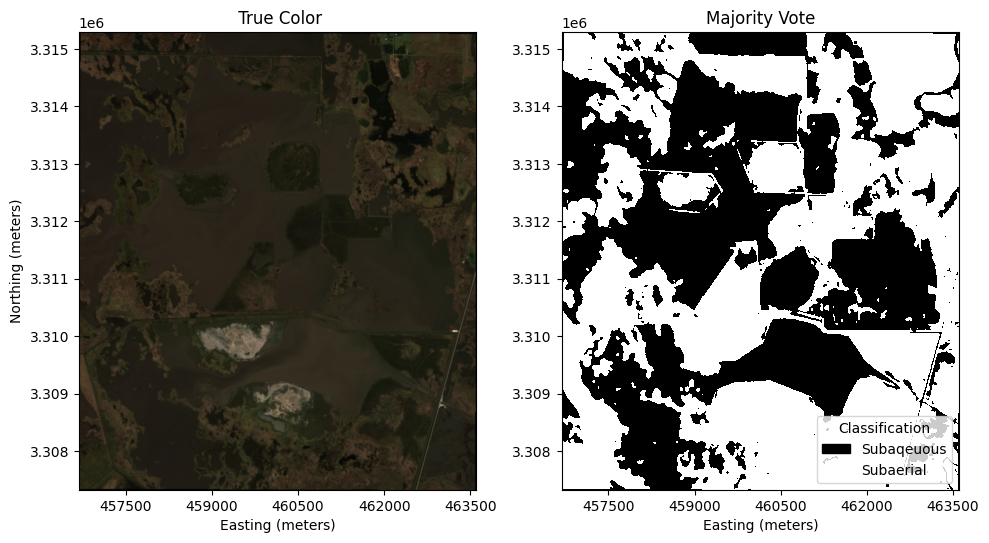

In [47]:
# compute the mode of the classifications
# can use this as the water mask for isce2 and mintpy processing

water_mask = mode(np.stack(majvote, axis=0), axis=0).mode[0]
plot_majvote_with_rgb(
    reg_rgb_ims[20],
    water_mask
)

# Visualize the classes

In [ ]:
for i, im in enumerate(reg_rgb_ims):
    plot_majvote_with_rgb(
        reg_rgb_ims[i],
        majvote[i]
    )

# Export Labeled Sentinel-2 labeled data

In [ ]:
# need to save corrected classifications as .tif files
for i, labels in enumerate(majvote):
    reference_tif = reg_rgb_ims[i]  # Path to the original Sentinel-1 image

    # outdir = os.path.join(reference_tif[:16], f's2classifications/majority')  # Define the directory path
    outdir = os.path.join(reference_tif[:30], f's2classifications/majority')  # Define the directory path
        
    os.makedirs(outdir, exist_ok=True)  # Ensure the directory exists
    output_tif = os.path.join(outdir, f'{reference_tif[-14:-4]}.tif')  # Define the output file name
    export_labels_to_tif(labels, reference_tif, output_tif)